In [14]:
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

warnings.filterwarnings('ignore')

In [2]:
# This function visualizes filters in matrix A. Each column of A is a
# filter. We will reshape each column into a square image and visualizes
# on each cell of the visualization panel.
# All other parameters are optional, usually you do not need to worry
# about it.
# opt_normalize: whether we need to normalize the filter so that all of
# them can have similar contrast. Default value is true.
# opt_graycolor: whether we use gray as the heat map. Default is true.
# opt_colmajor: you can switch convention to row major for A. In that
# case, each row of A is a filter. Default value is false.
# source: https://github.com/tsaith/ufldl_tutorial

In [3]:
def display_network(A, m = -1, n = -1):
    opt_normalize = True
    opt_graycolor = True
    
    # Rescale
    A = A - np.average(A)
    
    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    if m < 0 or n < 0:
        n = np.ceil(np.sqrt(col))
        m = np.ceil(col / n)

    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))
    
    if not opt_graycolor:
        image *= 0.1
    
    k = 0
    
    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue
            
            clim = np.max(np.abs(A[:, k]))
            
            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            
            k += 1
            
    return image

In [4]:
def display_color_network(A):
    """
    # display receptive field(s) or basis vector(s) for image patches
    #
    # A the basis, with patches as column vectors
    # In case the midpoint is not set at 0, we shift it dynamically
    :param A:
    :param file:
    :return:
    """
    
    if np.min(A) >= 0:
        A = A - np.mean(A)
    
    cols = np.round(np.sqrt(A.shape[1]))
    
    channel_size = A.shape[0] / 3
    dim = np.sqrt(channel_size)
    dimp = dim + 1
    rows = np.ceil(A.shape[1] / cols)
    
    B = A[0:channel_size, :]
    C = A[channel_size:2 * channel_size, :]
    D = A[2 * channel_size:3 * channel_size, :]
    
    B = B / np.max(np.abs(B))
    C = C / np.max(np.abs(C))
    D = D / np.max(np.abs(D))
    
    # Initialization of the image
    image = np.ones(shape=(dim * rows + rows - 1, dim * cols + cols - 1, 3))
    
    for i in range(int(rows)):
        for j in range(int(cols)):
            # This sets the patch
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 0] = B[:, i * cols + j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 1] = C[:, i * cols + j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 2] = D[:, i * cols + j].reshape(dim, dim)
        
    image = (image + 1) / 2
    
    return image

In [10]:
# set names to the paths because they're too long
data_path = 'D:\\Subjects_In_University\\Machine_Learning\\data\\KNN_Multinomial_Logistic_Regression'
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [12]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    # read data
    import gzip # to decompress gz (zip) file
    
    # open file training to read training data
    f_images = gzip.open(images_path,'r')
    
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    
    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    
    labels = np.zeros((real_num)).astype(np.int64)
    
    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
    
    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
    
        images = images[rand_id, :]
        labels = labels[rand_id,]
    
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [13]:
train_images, train_labels = get_mnist_data(
    train_images_path, train_labels_path, 5000, shuffle=True)

test_images, test_labels = get_mnist_data(
    test_images_path, test_labels_path, 10000, _is=False, shuffle=True)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

C:\Users\MY PC\AppData\Local\Temp\ipykernel_2848\2776198654.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


(5000, 784) (5000,)
(10000, 784) (10000,)


In [15]:
X0 = np.asarray(test_images)[:1000,:]/256.0
X = X0
K = 10
kmeans = KMeans(n_clusters=K).fit(X)

pred_label = kmeans.predict(X)

<class 'numpy.ndarray'>
(784, 10)


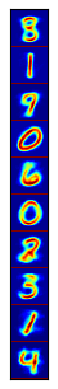

In [16]:
print(type(kmeans.cluster_centers_.T))
print(kmeans.cluster_centers_.T.shape)
A = display_network(kmeans.cluster_centers_.T, K, 1)

f1 = plt.imshow(A, interpolation='nearest', cmap = "jet")
f1.axes.get_xaxis().set_visible(False)
f1.axes.get_yaxis().set_visible(False)
plt.show()
# plt.savefig('a1.png', bbox_inches='tight')


# a colormap and a normalization instance
cmap = plt.cm.jet
norm = plt.Normalize(vmin=A.min(), vmax=A.max())

# map the normalized data to colors
# image is now RGBA (512x512x4)
image = cmap(norm(A))

In [21]:
N0 = 20
X1 = np.zeros((N0*K, 784))
X2 = np.zeros((N0*K, 784))

for k in range(K):
    Xk = X0[pred_label == k, :]

    center_k = [kmeans.cluster_centers_[k]]
    neigh = NearestNeighbors(n_neighbors=N0)
    neigh.fit(Xk)
    dist, nearest_id = neigh.kneighbors(center_k, N0)

    X1[N0*k: N0*k + N0,:] = Xk[nearest_id, :]
    X2[N0*k: N0*k + N0,:] = Xk[:N0, :]

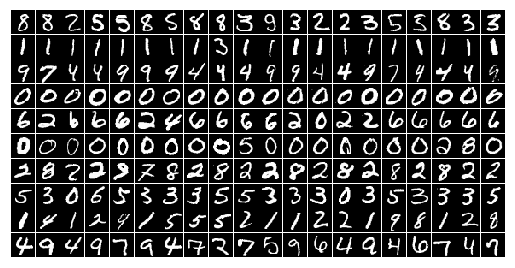

In [22]:
plt.axis('off')
A = display_network(X2.T, K, N0)
f2 = plt.imshow(A, interpolation='nearest' )
plt.gray()
plt.show()